# GCT to X-ID

What is the relationship between accuracy on the galaxy classification task (GCT) and accuracy on the cross-identification task?

In [1]:
import sys

import astropy.io.ascii as asc
import astropy.coordinates
import crowdastro.crowd.util
import cmocean
import h5py
import keras.models
import numpy
import scipy.spatial
import scipy.stats
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics

import pipeline

# Try to set up matplotlib fonts.
import matplotlib

# http://bkanuka.com/articles/native-latex-plots/
def figsize(scale):
    fig_width_pt = 240.0
    inches_per_pt = 1.0/72.27
    golden_mean = (numpy.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale
    fig_height = fig_width*golden_mean
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": figsize(0.9),
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",
        r"\usepackage[T1]{fontenc}",
    ]
}
matplotlib.rcParams.update(pgf_with_latex)

swire_names_cdfs, swire_coords_cdfs, swire_features_cdfs = pipeline.generate_swire_features(field='cdfs')
swire_names_elais, swire_coords_elais, swire_features_elais = pipeline.generate_swire_features(field='elais')
swire_labels_cdfs = pipeline.generate_swire_labels(swire_names_cdfs, swire_coords_cdfs, field='cdfs')
swire_labels_elais = pipeline.generate_swire_labels(swire_names_elais, swire_coords_elais, field='elais')
(atlas_train_sets_cdfs, atlas_test_sets_cdfs), (swire_train_sets_cdfs, swire_test_sets_cdfs) = pipeline.generate_data_sets(swire_coords_cdfs, swire_labels_cdfs, field='cdfs')
(atlas_train_sets_elais, atlas_test_sets_elais), (swire_train_sets_elais, swire_test_sets_elais) = pipeline.generate_data_sets(swire_coords_elais, swire_labels_elais, field='elais')

table = asc.read('/Users/alger/data/Crowdastro/one-table-to-rule-them-all.tbl')

FALLOFF_SIGMA = 1 / 120
SEARCH_RADIUS = 1 / 60


import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [2]:
swire_tree = scipy.spatial.KDTree(swire_coords_cdfs)

In [3]:
swire_name_to_index = {j:i for i, j in enumerate(swire_names_cdfs)}

In [4]:
_atlas_to_nearby_features = {}
_atlas_to_nearby_names = {}
_atlas_to_nearby_gaussians = {}
def get_xid_acc(classifier, quadrant):
    n_correct = 0
    n_total = 0
    for atlas in atlas_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0]:
        row = table[table['Key'] == atlas][0]
        ra = row['Component RA (Franzen)']
        dec = row['Component DEC (Franzen)']
        swire = row['Source SWIRE (Norris)']
        if not swire.startswith('SWIRE'):
            # Skip objects without a SWIRE host.
            continue

        # Find candidate hosts.
        if atlas in _atlas_to_nearby_features:
            nearby_features = _atlas_to_nearby_features[atlas]
            nearby_names = _atlas_to_nearby_names[atlas]
            nearby_gaussians = _atlas_to_nearby_gaussians[atlas]
        else:
            nearby = swire_tree.query_ball_point(numpy.array([ra, dec]), SEARCH_RADIUS)
            nearby_features = swire_features_cdfs[nearby]
            scoords = astropy.coordinates.SkyCoord(ra=ra, dec=dec, unit='deg')
            nearby_scoords = astropy.coordinates.SkyCoord(
                ra=swire_coords_cdfs[nearby, 0], dec=swire_coords_cdfs[nearby, 1], unit='deg')
            separations = numpy.array(scoords.separation(nearby_scoords).deg)
            nearby_gaussians = scipy.stats.norm.pdf(separations, scale=FALLOFF_SIGMA)
            nearby_names = [swire_names_cdfs[n] for n in nearby]
            _atlas_to_nearby_features[atlas] = nearby_features
            _atlas_to_nearby_names[atlas] = nearby_names
            _atlas_to_nearby_gaussians[atlas] = nearby_gaussians
        if not nearby_names:
            # No candidates.
            continue

        # Predict class probabilities.
        atpreds = classifier.predict_proba(nearby_features)
        if len(atpreds.shape) == 1:  # CNN
            pass
        elif atpreds.shape[1] == 2:  # LR
            atpreds = atpreds[:, 1]
        else:  # RF
            atpreds = atpreds[:, 0]

        # Multiply by Gaussians.
        atpreds *= nearby_gaussians

        # Cross-identify.
        name = nearby_names[numpy.argmax(atpreds)]
        n_correct += name == swire
        n_total += 1
    return n_correct / n_total

In [ ]:
def get_gct_accs(classifier, quadrant, fit_threshold=True) -> ('balanced accuracy', 'auc'):
    train_features = swire_features_cdfs[swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant]]
    test_features = swire_features_cdfs[swire_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant]]
    train_labels = swire_labels_cdfs[swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant], 0]
    test_labels = swire_labels_cdfs[swire_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant], 0]

    # Pick a new threshold that maximises balanced accuracy.
    if fit_threshold:
        thresholds = numpy.linspace(0.4, 0.7, 100)
        pred_probs = classifier.predict_proba(train_features)
        if len(pred_probs.shape) == 1:  # CNN
            pass
        elif pred_probs.shape[1] == 2:  # LR
            pred_probs = pred_probs[:, 1]
        else:  # RF
            pred_probs = pred_probs[:, 0]
        threshold_bas = []
        for threshold in thresholds:
            try:
                ba = crowdastro.crowd.util.balanced_accuracy(
                    train_labels,
                    pred_probs > threshold)
            except ValueError:
                ba = 0.5
            threshold_bas.append(ba)
        best_threshold = thresholds[numpy.argmax(threshold_bas)]
    else:
        best_threshold = 0.5

    # Test on SWIRE (GCT).
    pred_probs = classifier.predict_proba(test_features)
    if len(pred_probs.shape) == 1:  # CNN
        pass
    elif pred_probs.shape[1] == 2:  # LR
        pred_probs = pred_probs[:, 1]
    else:  # RF
        pred_probs = pred_probs[:, 0]
    pred_labels = pred_probs > best_threshold
    auc = sklearn.metrics.roc_auc_score(test_labels, pred_probs)
    ba = crowdastro.crowd.util.balanced_accuracy(test_labels, pred_labels)
    return ba, auc

In [ ]:
# Generate some classifiers and test them.
numpy.random.seed(0)

accs_gct = []
accs_xid = []
aucs_gct = []
n_max = swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris']].sum(axis=0).min()
# Train 16 LR models (four per quadrant).
# I want an ensemble of models so that any correlations we get by using the same model
# twice, but noised the second time around, are averaged out.
lrs = {q: [] for q in range(4)}
for _ in range(4):
    for quadrant in range(4):
        print('Quadrant:', quadrant)
        lr = sklearn.linear_model.LogisticRegression(class_weight='balanced',
                                                     C=100000.0)

        train = list(swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0])
        train_features = swire_features_cdfs[train]
        train_labels = swire_labels_cdfs[train, 0]
        lr.fit(train_features, train_labels)
        lrs[quadrant].append(lr)

for i in range(40):
    print(i)
    for q, lrs_ in lrs.items():
        for lr in lrs_:
            ba, auc = get_gct_accs(lr, q)
            acc = get_xid_acc(lr, q)
            accs_xid.append(acc)
            accs_gct.append(ba)
            aucs_gct.append(auc)

            # Noise the LR weights to drop the accuracies.
            lr.coef_ += numpy.random.normal(scale=lr.coef_.std() / 100, size=lr.coef_.shape)

Quadrant: 0
Quadrant: 1
Quadrant: 2
Quadrant: 3
Quadrant: 0
Quadrant: 1
Quadrant: 2
Quadrant: 3
Quadrant: 0
Quadrant: 1
Quadrant: 2
Quadrant: 3
Quadrant: 0
Quadrant: 1
Quadrant: 2
Quadrant: 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [ ]:
def density_scatter(xs, ys, cmap='summer', log=False, marker='o', **kwargs):
    xy = numpy.vstack([xs, ys])
    z = scipy.stats.gaussian_kde(xy)(xy)
    if log:
        z = numpy.log(z)
    plt.scatter(xs, ys, c=z, marker=marker, cmap=cmap, **kwargs)

In [ ]:
accs_gct_ = numpy.array(accs_gct)
accs_xid_ = numpy.array(accs_xid)
density_scatter(accs_gct_ * 100, accs_xid_ * 100,
                cmap=cmocean.cm.dense, edgecolors='k')
plt.xlabel('GCT balanced accuracy')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
# plt.xscale('log')
# plt.yscale('log')
# plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-xid-lr.pdf')

In [ ]:
aucs_gct_ = numpy.array(aucs_gct)
accs_xid_ = numpy.array(accs_xid)
density_scatter(aucs_gct_ * 100, accs_xid_ * 100,
                cmap=cmocean.cm.dense, edgecolors='k')
plt.xlabel('GCT AUC')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')

In [ ]:
aucs_gct_ = numpy.array(aucs_gct)
accs_gct_ = numpy.array(accs_gct)
accs_xid_ = numpy.array(accs_xid)
density_scatter(accs_gct_ * 100, accs_xid_ * 100,
                cmap='Greens', edgecolors='k',
                label='BA', marker='s')
density_scatter(aucs_gct_ * 100, accs_xid_ * 100,
                cmap='Blues', edgecolors='k',
                label='AUC', marker='o')
plt.xlabel('GCT performance')
plt.ylabel('X-ID accuracy')
plt.legend()
plt.grid(color='lightgrey', axis='y')

In [ ]:
bin_means = []
bin_stdevs = []
n_bins = 10
bins = numpy.linspace(accs_gct_.min(), accs_gct_.max(), n_bins)
bins_ = numpy.digitize(accs_gct_, bins=bins)
for b in range(n_bins):
    bin_means.append(accs_xid_[bins_ == b].mean())
    bin_stdevs.append(accs_xid_[bins_ == b].std())
bin_means = numpy.array(bin_means)
bin_stdevs = numpy.array(bin_stdevs)
plt.plot(bins, bin_means)
plt.fill_between(bins, bin_means - bin_stdevs, bin_means + bin_stdevs, alpha=0.2)

In [ ]:
# Generate some classifiers and test them.
numpy.random.seed(0)

accs_gct_rf = []
accs_xid_rf = []
aucs_gct_rf = []
rfs = {q: [] for q in range(4)}
n_max = swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris']].sum(axis=0).min()
# Train 16 * 40 RF models (4 * 40 per quadrant).
# We can't add noise to random forests so we'll have to retrain them with subsets of the training data.
for quadrant in range(4):
    print(quadrant)
    train = list(swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], quadrant].nonzero()[0])
    for i in range(4 * 40):
        subset_size = numpy.linspace(10, 500, 4 * 40, dtype=int)[i]
        rf = sklearn.ensemble.RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     min_samples_leaf=45)
        numpy.random.shuffle(train)
        train_subset = train[:subset_size]
        train_features = swire_features_cdfs[train_subset]
        train_labels = swire_labels_cdfs[train_subset, 0]
        rf.fit(train_features, train_labels)
        rfs[quadrant].append(rf)

        ba, auc = get_gct_accs(rf, q)
        acc = get_xid_acc(rf, q)
        accs_xid_rf.append(acc)
        accs_gct_rf.append(ba)
        aucs_gct_rf.append(auc)

In [ ]:
accs_gct_rf_ = numpy.array(accs_gct_rf)
accs_xid_rf_ = numpy.array(accs_xid_rf)[accs_gct_rf_ > 0.5]
accs_gct_rf_ = numpy.array(accs_gct_rf)[accs_gct_rf_ > 0.5]
density_scatter(accs_gct_rf_ * 100, accs_xid_rf_ * 100,
                cmap=cmocean.cm.dense, edgecolors='k')
plt.xlabel('GCT balanced accuracy')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
# plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-xid-rf.pdf')

In [ ]:
accs_gct_rf_ = numpy.array(accs_gct_rf)
accs_xid_rf_ = numpy.array(accs_xid_rf)[accs_gct_rf_ > 0.5]
aucs_gct_rf_ = numpy.array(aucs_gct_rf)[accs_gct_rf_ > 0.5]
density_scatter(aucs_gct_rf_ * 100, accs_xid_rf_ * 100,
                cmap=cmocean.cm.dense, edgecolors='k')
plt.xlabel('GCT balanced accuracy')
plt.ylabel('X-ID accuracy')
plt.grid(color='lightgrey', axis='y')
# plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/gct-to-xid-rf.pdf')

In [ ]:
accs_gct_rf_ = numpy.array(accs_gct_rf)
aucs_gct_rf_ = numpy.array(aucs_gct_rf)[accs_gct_rf_ > 0.5]
accs_xid_rf_ = numpy.array(accs_xid_rf)[accs_gct_rf_ > 0.5]
accs_gct_rf_ = numpy.array(accs_gct_rf)[accs_gct_rf_ > 0.5]
density_scatter(accs_gct_rf_ * 100, accs_xid_rf_ * 100,
                cmap='Greens', edgecolors='k',
                label='BA', marker='s')
density_scatter(aucs_gct_rf_ * 100, accs_xid_rf_ * 100,
                cmap='Blues', edgecolors='k',
                label='AUC', marker='o')
plt.xlabel('GCT performance')
plt.ylabel('X-ID accuracy')
plt.legend()
plt.grid(color='lightgrey', axis='y')

In [ ]:
raise NotImplementedError()
# Generate some classifiers and test them.
numpy.random.seed(0)

accs_gct_cnn = []
accs_xid_cnn = []
aucs_gct_cnn = []
n_max = swire_train_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris']].sum(axis=0).min()
# Generate 4 CNN models (one per quadrant). Noise them to get new classifiers.
cnns = {q: [] for q in range(4)}
for _ in range(1):
    for quadrant in range(4):
        print('Quadrant:', quadrant)
        # Load the trained CNN from file.
        with open('/Users/alger/data/Crowdastro/model_03_06_17.json') as f:
            cnn = keras.models.model_from_json(f.read())
            path = '/Users/alger/data/Crowdastro/weights_03_06_17/weights_{}_norris.h5'.format(quadrant)
            cnn.load_weights(path)
        cnns[quadrant].append(pipeline.CNN(cnn))

for i in range(10):
    print('Iteration', i)
    for q, cnns_ in cnns.items():
        print('Quadrant', q)
        for cnn in cnns_:
            ba, auc = get_gct_accs(cnn, q)
            acc = get_xid_acc(cnn, q)
            accs_xid_cnn.append(acc)
            accs_gct_cnn.append(ba)
            aucs_gct_cnn.append(auc)

            # Noise the CNN weights to drop the accuracies.
            weights = cnn._cnn.get_weights()
            for i in range(len(weights)):
                w = weights[i]
                w += numpy.random.normal(scale=w.std() / 5, size=w.shape)
            cnn._cnn.set_weights(weights)

In [ ]:
plt.scatter(accs_gct_cnn, accs_xid_cnn)

In [ ]:
rf_line = scipy.stats.linregress(accs_gct_rf_[accs_gct_rf_ > 0.51], accs_xid_rf_[accs_gct_rf_ > 0.51])
lr_line = scipy.stats.linregress(accs_gct_[accs_gct_ > 0.51], accs_xid_[accs_gct_ > 0.51])
print('rf: {}'.format(rf_line.rvalue))
print('lr: {}'.format(lr_line.rvalue))

In [ ]:
fs = figsize(0.9)
fs = fs[0] * 1.5, fs[1] * 3
fig = plt.figure(figsize=fs)
plt.subplot(2, 1, 1)
density_scatter(
    accs_gct_rf_[accs_gct_rf_ > 0.51] * 100,
    accs_xid_rf_[accs_gct_rf_ > 0.51] * 100, log=True, cmap='cool')
plt.plot(numpy.array(sorted(accs_gct_rf_[accs_gct_rf_ > 0.51])) * 100,
         numpy.array(sorted(accs_gct_rf_[accs_gct_rf_ > 0.51])) * rf_line.slope * 100 + rf_line.intercept * 100,
         linewidth=1, color='k', linestyle='--')
plt.ylabel('X-ID accuracy (per cent)')
plt.xticks([])
plt.annotate('RF', (50, 85))
plt.xlim((45, 100))
plt.ylim((40, 100))
plt.yticks(range(50, 100, 10))
plt.subplot(2, 1, 2)
density_scatter(accs_gct_[accs_gct_ > 0.51] * 100, accs_xid_[accs_gct_ > 0.51] * 100, log=True, cmap='cool')
plt.plot(numpy.array(sorted(accs_gct_[accs_gct_ > 0.51])) * 100,
         numpy.array(sorted(accs_gct_[accs_gct_ > 0.51])) * lr_line.slope * 100 + lr_line.intercept * 100,
         linewidth=1, color='k', linestyle='--')
plt.xlabel('GCT balanced accuracy (per cent)')
plt.ylabel('X-ID accuracy (per cent)')
plt.xlim((45, 100))
plt.ylim((40, 100))
plt.yticks(range(50, 100, 10))
plt.annotate('LR', (50, 85))
import matplotlib.cm, matplotlib.colors, matplotlib.colorbar
cbar_ax = fig.add_axes([0.75, 0.12, 0.05, 0.76])
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cb1 = matplotlib.colorbar.ColorbarBase(cbar_ax,
                                       norm=norm,
                                       orientation='vertical',
                                       cmap='cool')
cb1.set_label('log(classifier density)')
plt.subplots_adjust(hspace=0, right=0.7, left=0.2)
plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/images/gct-to-xid.pdf')

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(accs_gct_[accs_gct_ > 0.51], accs_xid_[accs_gct_ > 0.51])
slope_rf, intercept_rf, r_value_rf, p_value_rf, std_err_rf = scipy.stats.linregress(accs_gct_rf_[accs_gct_rf_ > 0.51], accs_xid_rf_[accs_gct_rf_ > 0.51])

print(r_value**2, r_value_rf**2)
print(std_err, std_err_rf)

In [ ]:
aucs_rf_ = numpy.array(aucs_rf)
xs = numpy.log(aucs_rf_[aucs_rf_ > 0.51])
ys = numpy.log(accs_xid_rf_[aucs_rf_ > 0.51])
plt.scatter(xs, ys)
m, b = numpy.polyfit(xs, ys, 1)
plt.plot(xs, m * xs + b, c='black')
print(m, b)
plt.xlabel('log(GCT AUC)')
plt.ylabel('log(XID accuracy)')
# N = 20
# plt.scatter(xs, numpy.exp(-N / 200) * xs ** N + (1 - numpy.exp(-N / 200)))

\begin{align*}
    log(XID) &= m \log(AUC) + b\\
        &= \log(AUC^m) + b\\
    XID &= \exp(b) AUC^m\\
\end{align*}

In [ ]:
numpy.exp(0.19)

So only the ~8 galaxies closest the radio object matter under my model. What's the expected radius we need to get $N$ galaxies?

$$R_N = \sqrt{\frac{N}{\pi\rho}}$$

Do the units check out?

$$m = \sqrt{\frac{1}{1 \times \frac{1}{m^2}}} = m$$

Yup, looks good. What's the average density of galaxies, per square arcmin?

In [66]:
densities = []
for atlas in atlas_test_sets_cdfs[:, pipeline.SET_NAMES['RGZ & Norris'], 0].nonzero()[0]:
    row = table[table['Key'] == atlas][0]
    ra = row['Component RA (Franzen)']
    dec = row['Component DEC (Franzen)']
    swire = row['Source SWIRE (Norris)']
    if not swire.startswith('SWIRE'):
        continue
    nearby = swire_tree.query_ball_point(numpy.array([ra, dec]), 1 / 60)
    n = len(nearby)
    area = numpy.pi
    densities.append(n / area)
print(numpy.mean(densities))

8.00018847275


So

$$R_8 = \sqrt{\frac{8}{8 \pi}} = \frac{1}{\sqrt{\pi}} \approx 0.56 \text{ arcmin}$$

is the radius in which we expect to find "difficult" examples. What's that look like on an image?

In [71]:
import aplpy

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -6.858e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.227e+02 [aplpy.core]


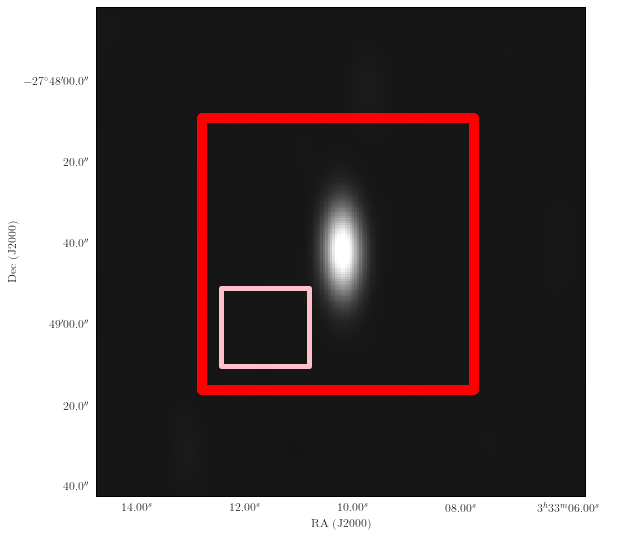

In [105]:
f = aplpy.FITSFigure('/Users/alger/data/RGZ/cdfs/2x2/CI0020_radio.fits')
f.show_grayscale()
f.show_rectangles(*f.pixel2world(100, 100), 2 * 0.56 / 60, 2 * 0.56 / 60, edgecolor='red', linewidth=10)
f.show_rectangles(*f.pixel2world(70, 70),
                  *numpy.abs(numpy.array(f.pixel2world(100, 100)) - numpy.array(f.pixel2world(132, 132))),
                  edgecolor='pink', linewidth=5)


(53.300339438393884, -27.818536047903606)